# Exercises

Source: http://web.archive.org/web/20160830014637/https://gym.openai.com/docs/rl#id16

### Algorithm 1: Cross Entropy Method

>Initialize $\mu \in \mathbb{R}^d, \sigma \in \mathbb{R}^d<br/>
>For iteration = 1, 2, ...<br/>
>
>&nbsp;&nbsp;&nbsp;&nbsp;Collect $n$ samples of $\theta_i \sim N(\mu, diag(\sigma))$<br/>
>&nbsp;&nbsp;&nbsp;&nbsp;Perform a noise evaluation $f(\theta_i, \zeta_i)$ on each one<br/>
>&nbsp;&nbsp;&nbsp;&nbsp;Select the top $p%$ of samples $(e.g. p = 20)$, which we'll call the "elite set"<br/>
>&nbsp;&nbsp;&nbsp;&nbsp;Fit a Gaussian distribution, with diagonal covariance, to the elite set, obtaining a new $\mu$, $\sigma$.
>
>Return the final $\mu$

In the RL setting, we evaluate $f(θ_i, ζ_i)$ by executing the policy parameterized by $θ_i$ for one or more episodes, and computing the total return.

## 2.1 Exercises

### 1. Apply the cross-entropy method to the CartPole environment

In [1]:
class EvalParams:
    def __init__(self, n_samples=100, elite_percent=0.2, iterations=50, noise_factor=0.1, seed: int | None = None):
        self.n_samples = n_samples
        self.elite_percent = elite_percent
        self.iterations = iterations
        self.noise_factor = noise_factor
        self.seed = seed

In [2]:
import numpy as np
import typing

def cross_entropy_method(dimension: int, evaluator: typing.Callable[[np.ndarray, float], float], params=EvalParams()) -> np.ndarray:
    n_samples = params.n_samples
    elite_percent = params.elite_percent
    iterations = params.iterations
    noise_factor = params.noise_factor
    seed = params.seed

    if seed:
        np.random.seed(seed)

    # Step 1: Initialize μ and σ
    mu = np.zeros(dimension)  # Initial mean
    sigma = np.ones(dimension)  # Initial standard deviation (diagonal of covariance)

    n_elite = int(elite_percent * n_samples)  # Number of elite samples

    for iteration in range(iterations):
        # Step 2: Collect n samples of θ_i ∼ N(μ, diag(σ))
        samples = np.random.multivariate_normal(mu, np.diag(sigma), n_samples)

        # Step 3: Perform a noisy evaluation f(θ_i, ζ_i) on each one
        evaluations = np.array([evaluator(theta, noise_factor) for theta in samples])

        # Step 4: Select the top p% of samples (elite set)
        elite_indices = evaluations.argsort()[-n_elite:]  # Indices of top p% evaluations
        elite_samples = samples[elite_indices]

        # Step 5: Fit a new Gaussian distribution to the elite set (new μ, σ)
        mu = np.mean(elite_samples, axis=0)
        sigma = np.std(elite_samples, axis=0)

        best_evaluation = np.max(evaluations)
        worst_evaluation = np.min(evaluations)
        mean_evaluation = np.mean(evaluations)
        std_evaluation = np.std(evaluations)

        # Print progress
        iter_str = f"Evaluation at iteration {iteration + 1}"
        best_str = f"Best = {best_evaluation}"
        worst_str = f"Worst = {worst_evaluation}"
        mean_str = f"Mean = {mean_evaluation}"
        std_str = f"Std = {std_evaluation}"
        print(f"> {iter_str}: {best_str} | {worst_str} | {mean_str} | {std_str}")

    # Final evaluation
    evaluations = np.array([evaluator(theta, 0) for theta in samples])

    best_str = f"Best = {np.max(evaluations)}"
    worst_str = f"Worst = {np.min(evaluations)}"
    mean_str = f"Mean = {np.mean(evaluations)}"
    std_str = f"Std = {np.std(evaluations)}"
    print(f"Final evaluation (no noise): {best_str} | {worst_str} | {mean_str} | {std_str}")

    return mu

In [3]:
# Example usage

# Noisy evaluation function (replace this with your real function)
def evaluate(theta, noise_factor=0.1):
    # Example evaluation: simple quadratic function with noise
    noise = np.random.randn() * noise_factor
    return -np.sum(theta**2) + noise

dimension = 5  # Dimensionality of the problem
final_mu = cross_entropy_method(dimension, evaluate, params=EvalParams(seed=42))
print("Final μ:", final_mu)

> Evaluation at iteration 1: Best = -0.7163898685709817 | Worst = -16.630537879032783 | Mean = -4.81642544861259 | Std = 3.0088976229443496
> Evaluation at iteration 2: Best = -0.030286620483872893 | Worst = -8.395106551733688 | Mean = -2.695192797417966 | Std = 1.7424096212903402
> Evaluation at iteration 3: Best = -0.183146818144696 | Worst = -5.784244448889563 | Mean = -1.8918651297640066 | Std = 1.142651509511421
> Evaluation at iteration 4: Best = -0.01041125216644051 | Worst = -5.965552672451809 | Mean = -1.7013528648158394 | Std = 1.1336715866212825
> Evaluation at iteration 5: Best = -0.09221563865514357 | Worst = -8.175666769391277 | Mean = -1.4474574674884966 | Std = 1.0886044912391468
> Evaluation at iteration 6: Best = -0.14374786467820738 | Worst = -4.537120205517496 | Mean = -1.7124577548664752 | Std = 0.9337543613322696
> Evaluation at iteration 7: Best = -0.016785042731554983 | Worst = -5.338396521998412 | Mean = -1.6470026657881511 | Std = 1.0951476764484096
> Evaluati

In [4]:
from gymnasium import Env

class EvalParams:
    def __init__(self, n_samples=100, elite_percent=0.2, iterations=50, noise_factor=0.1, seed: int | None = None):
        self.n_samples = n_samples
        self.elite_percent = elite_percent
        self.iterations = iterations
        self.noise_factor = noise_factor
        self.seed = seed

def evaluate_cem(
    env: Env,
    action_selector: typing.Callable[[typing.Any, np.ndarray], typing.Any],
    params=EvalParams(),
):
    def evaluate_episode(theta: np.ndarray, noise_factor: float):
        total_reward = 0
        state, _ = env.reset()
        done = False

        while not done:
            action = action_selector(state, theta)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward

        # Add noise to the total reward
        noise = np.random.randn() * noise_factor
        return total_reward * (1 + noise)

    dimension = env.observation_space.shape[0]  # Dimensionality of the problem
    final_mu = cross_entropy_method(dimension, evaluate_episode, params=params)
    print("Final μ:", final_mu)

In [5]:
import gymnasium as gym

def evaluate_cem_cartpole(params=EvalParams()):
    env = gym.make("CartPole-v1")

    def action_selector(state, theta):
        return 0 if np.dot(theta, state) < 0 else 1

    evaluate_cem(env=env, action_selector=action_selector, params=params)

# Test the function
evaluate_cem_cartpole(EvalParams(seed=42))

> Evaluation at iteration 1: Best = 496.8660451363414 | Worst = 6.3460463199680985 | Mean = 62.14343031230893 | Std = 100.99936464049134
> Evaluation at iteration 2: Best = 590.0470216455408 | Worst = 7.5744874588628495 | Mean = 177.70895482689178 | Std = 163.33633759437913
> Evaluation at iteration 3: Best = 566.4097070924529 | Worst = 7.230279069561599 | Mean = 247.7626461554364 | Std = 184.39754187800233
> Evaluation at iteration 4: Best = 656.8874266829997 | Worst = 8.822395421723407 | Mean = 363.1230694879481 | Std = 178.9453540330698
> Evaluation at iteration 5: Best = 618.193624730968 | Worst = 7.6902954801683885 | Mean = 361.6854206198233 | Std = 180.3306414697744
> Evaluation at iteration 6: Best = 620.5838337789211 | Worst = 8.809011927088964 | Mean = 365.8504831211093 | Std = 168.6659653377582
> Evaluation at iteration 7: Best = 613.6217360223442 | Worst = 8.637231609841473 | Mean = 384.160105606172 | Std = 161.58169435150535
> Evaluation at iteration 8: Best = 657.602836725

### 2. (Practice *) Apply it to the Swimmer environment, which has a continuous action space. Try artificially increasing the variance and gradually lowering this noise to zero.

In [6]:
def is_windows():
    import platform
    return platform.system() == "Windows"

def evaluate_cem_swimmer(params=EvalParams()):
    env = gym.make("Swimmer-v3")

    def action_selector(state, theta):
        return np.clip(np.dot(theta, state), -1, 1)

    evaluate_cem(env=env, action_selector=action_selector, params=params)

if not is_windows():
    # Test the function
    evaluate_cem_swimmer(EvalParams(seed=42))

## 3.5 Exercises

### 1. Implement a policy gradient algorithm and apply it to the CartPole environment. Compare the following variants:

$\quad a.\text{ }\widehat{A}_t = R$

$\quad b.\text{ }\widehat{A}_t = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + ... - V(s_t)$, with and without the discount and baseline (4 variants total).

In [7]:
import torch
import torch.nn.functional as F

# Define a simple policy network
class GradientPolicy(torch.nn.Module):
    def __init__(self, n_features: int, n_actions: int, hidden_dim: int = 128, p_dropout=0.6):
        super().__init__()
        self.output_dim = n_actions
        self.linear1 = torch.nn.Linear(n_features, hidden_dim)
        self.dropout = torch.nn.Dropout(p_dropout)
        self.linear2 = torch.nn.Linear(hidden_dim, n_actions)

    def forward(self, x):
        x = F.relu(self.dropout(self.linear1(x)))
        x = (
            F.softmax(self.linear2(x), dim=-1)
            if self.output_dim > 1
            else F.sigmoid(self.linear2(x))
        )
        return x

# This network is used to calculate the state-value and the baseline
class StateValueNetwork(torch.nn.Module):
    def __init__(self, n_states: int, hidden_dim: int = 128):
        super().__init__()
        self.linear1 = torch.nn.Linear(n_states, hidden_dim)
        self.linear2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = torch.relu(self.linear1(x))
        x = self.linear2(x)
        return x

class History:
    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []

    def add(self, state, action, reward):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)

    def clear(self):
        self.states.clear()
        self.actions.clear()
        self.rewards.clear()

def get_default_optimizer(model: torch.nn.Module, lr: float):
    return torch.optim.SGD(model.parameters(), lr=lr)

class Manager:
    def __init__(
        self,
        env: Env,
        policy: GradientPolicy,
        v_net: StateValueNetwork | None,
        discount=1.0,
        debug = False,
        get_policy_optimizer=get_default_optimizer,
        get_v_optimizer=get_default_optimizer,
    ):
        self.env = env
        self.policy = policy
        self.v_net = v_net
        self.discount = discount
        self.debug = debug
        self.get_policy_optimizer = get_policy_optimizer
        self.get_v_optimizer = get_v_optimizer

    def run_episode(self, update_v: bool, policy_optimizer: torch.optim.Optimizer, v_optimizer: torch.optim.Optimizer):
        env = self.env
        policy = self.policy
        v_net = self.v_net
        discount = self.discount
        debug = self.debug

        policy_optimizer.zero_grad()
        if v_optimizer is not None:
            v_optimizer.zero_grad()

        state, _ = env.reset()
        done = False
        log_actions: list[torch.Tensor] = []
        history = History()

        if debug:
            print('actions: ', end='')

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            action_probs = policy(state_tensor)
            action = torch.multinomial(action_probs, 1).item()
            log_actions.append(torch.log(action_probs[action]))

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            history.add(state, action, reward)

            state = next_state

            if debug:
                print(f'{action} ({action_probs[action]}), ', end='')

        if debug:
            print('')

        R = 0
        advantage_list: list[float] = []
        baselines = (
            v_net(torch.tensor(history.states, dtype=torch.float32)).squeeze(-1)
            if v_net is not None
            else torch.zeros(len(history.states))
        )
        detached_baselines = baselines.detach()
        cum_rewards: list[float] = []

        for t in range(len(history.rewards)-1, -1, -1):
            R = history.rewards[t] + discount * R
            cum_rewards.append(R)
            advantage = R - detached_baselines[t]
            advantage_list.append(advantage)

        advantage_list.reverse()
        cum_rewards.reverse()

        A = torch.stack(advantage_list)

        log_pi = torch.stack(log_actions).squeeze(-1)
        loss_policy = -torch.sum(log_pi * A)

        if debug:
            print('steps', len(A))
            print('actions', history.actions)
            print('loss', type(loss_policy), loss_policy)
        loss_policy.backward()

        policy_optimizer.step()
        if update_v and v_optimizer is not None:
            loss_v = F.mse_loss(baselines, torch.tensor(cum_rewards, dtype=torch.float32))
            loss_v.backward()
            v_optimizer.step()

        return sum(history.rewards)

    def train(self, title, n_episodes: int, update_v_every=10):
        import matplotlib.pyplot as plt

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        for alpha in [0.01, 0.005, 0.001]:
            policy_optimizer = self.get_policy_optimizer(self.policy, lr=alpha)
            v_optimizer = (
                self.get_v_optimizer(self.v_net, lr=alpha)
                if self.v_net is not None
                else None)

            all_rewards: list[float] = []
            for i in range(n_episodes):
                rewards = self.run_episode(
                    update_v=(i % update_v_every == 0),
                    policy_optimizer=policy_optimizer,
                    v_optimizer=v_optimizer)
                all_rewards.append(rewards)

                if (i+1) % max(n_episodes // 20, 1) == 0:
                    print(f"[alpha={alpha}] Episode {i + 1}: {rewards}")

            # plot with a moving avg of 10 episodes
            n = 10
            cumsum, moving_aves = [0], []
            for i, x in enumerate(all_rewards, 1):
                cumsum.append(cumsum[i-1] + x)
                if i >= n:
                    moving_ave = (cumsum[i] - cumsum[i-n]) / n
                    moving_aves.append(moving_ave)

            ax1.plot(all_rewards, label=f"alpha={alpha}")
            ax2.plot(moving_aves, label=f"alpha={alpha}")

        plt.suptitle(title)
        ax1.set_title('Rewards')
        ax2.set_title(f"Average rewards over {n} episodes")
        ax1.set_xlabel("Episode")
        ax2.set_xlabel("Episode")
        plt.ylabel("Total reward")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

    def predict(self, state):
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32)
            action_probs = self.policy(state_tensor)
            return torch.argmax(action_probs).item()

[Start] 3.5.1. without discount and without baseline (A_t = R)
--------------------------------------------------------------------------------
[alpha=0.01] Episode 50: 10.0
[alpha=0.01] Episode 100: 10.0
[alpha=0.01] Episode 150: 11.0
[alpha=0.01] Episode 200: 9.0
[alpha=0.01] Episode 250: 8.0
[alpha=0.01] Episode 300: 9.0
[alpha=0.01] Episode 350: 10.0
[alpha=0.01] Episode 400: 8.0
[alpha=0.01] Episode 450: 10.0
[alpha=0.01] Episode 500: 11.0
[alpha=0.01] Episode 550: 10.0
[alpha=0.01] Episode 600: 10.0
[alpha=0.01] Episode 650: 10.0
[alpha=0.01] Episode 700: 9.0
[alpha=0.01] Episode 750: 10.0
[alpha=0.01] Episode 800: 10.0
[alpha=0.01] Episode 850: 9.0
[alpha=0.01] Episode 900: 9.0
[alpha=0.01] Episode 950: 9.0
[alpha=0.01] Episode 1000: 10.0
[alpha=0.005] Episode 50: 9.0
[alpha=0.005] Episode 100: 10.0
[alpha=0.005] Episode 150: 9.0
[alpha=0.005] Episode 200: 10.0
[alpha=0.005] Episode 250: 9.0
[alpha=0.005] Episode 300: 10.0
[alpha=0.005] Episode 350: 10.0
[alpha=0.005] Episode 40

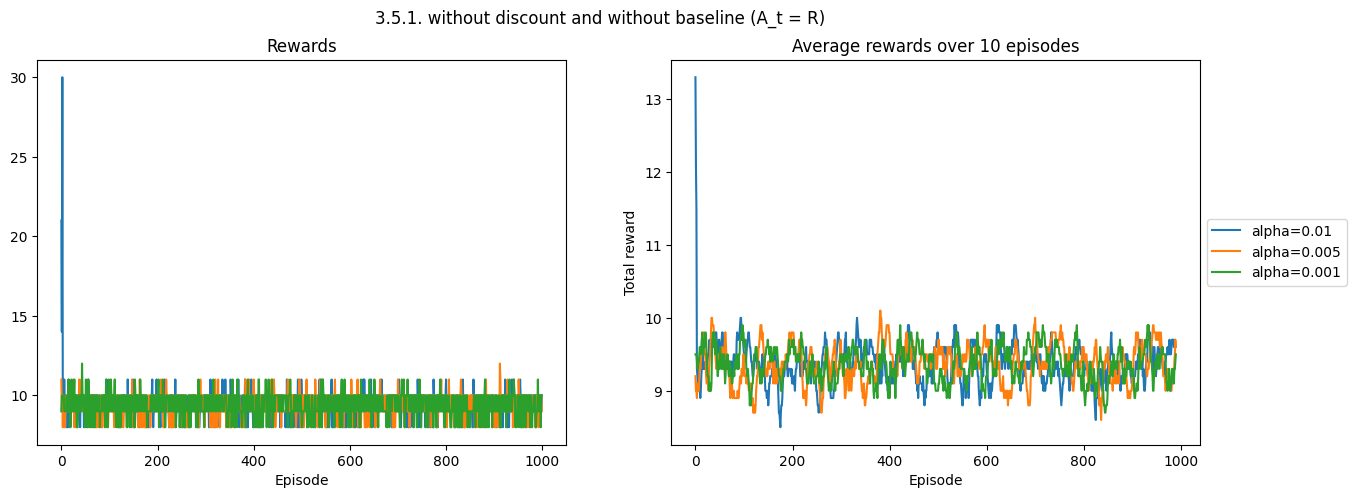

--------------------------------------------------------------------------------
[End] 3.5.1. without discount and without baseline (A_t = R)
[Start] 3.5.1. with discount and without baseline
--------------------------------------------------------------------------------
[alpha=0.01] Episode 50: 10.0
[alpha=0.01] Episode 100: 10.0
[alpha=0.01] Episode 150: 9.0
[alpha=0.01] Episode 200: 9.0
[alpha=0.01] Episode 250: 8.0
[alpha=0.01] Episode 300: 22.0
[alpha=0.01] Episode 350: 9.0
[alpha=0.01] Episode 400: 10.0
[alpha=0.01] Episode 450: 10.0
[alpha=0.01] Episode 500: 10.0
[alpha=0.01] Episode 550: 9.0
[alpha=0.01] Episode 600: 10.0
[alpha=0.01] Episode 650: 10.0
[alpha=0.01] Episode 700: 10.0
[alpha=0.01] Episode 750: 10.0
[alpha=0.01] Episode 800: 8.0
[alpha=0.01] Episode 850: 9.0
[alpha=0.01] Episode 900: 10.0
[alpha=0.01] Episode 950: 10.0
[alpha=0.01] Episode 1000: 9.0
[alpha=0.005] Episode 50: 10.0
[alpha=0.005] Episode 100: 8.0
[alpha=0.005] Episode 150: 10.0
[alpha=0.005] Episode

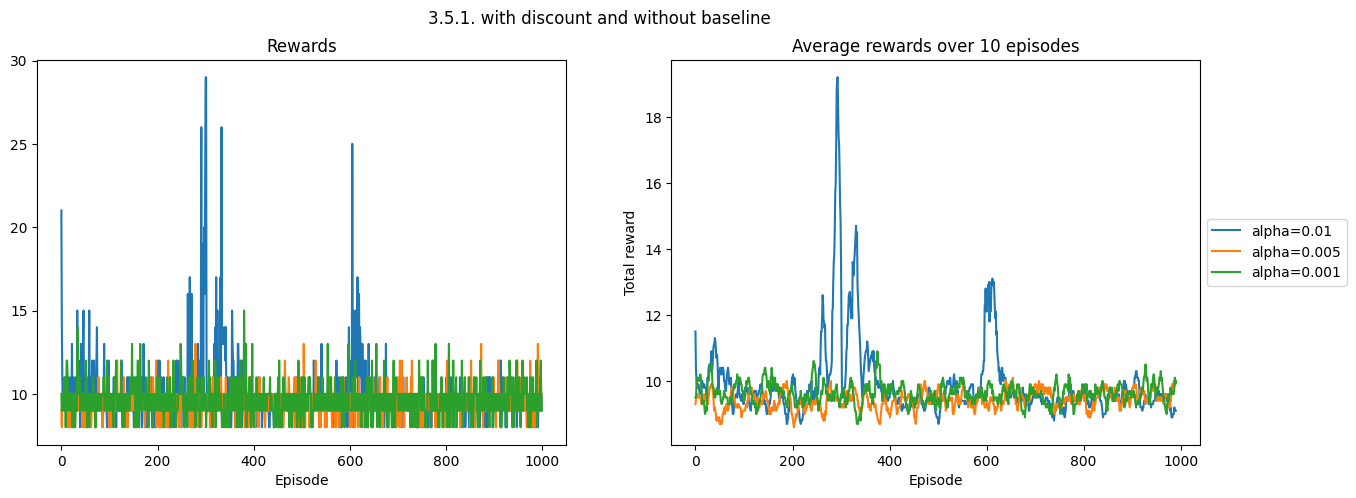

--------------------------------------------------------------------------------
[End] 3.5.1. with discount and without baseline
[Start] 3.5.1. without discount and with baseline
--------------------------------------------------------------------------------


C:\Users\Asus\AppData\Local\Temp\ipykernel_18760\2603588583.py:112: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  v_net(torch.tensor(history.states, dtype=torch.float32)).squeeze(-1)


[alpha=0.01] Episode 50: 14.0
[alpha=0.01] Episode 100: 10.0
[alpha=0.01] Episode 150: 15.0
[alpha=0.01] Episode 200: 13.0
[alpha=0.01] Episode 250: 10.0
[alpha=0.01] Episode 300: 13.0
[alpha=0.01] Episode 350: 11.0
[alpha=0.01] Episode 400: 14.0
[alpha=0.01] Episode 450: 21.0
[alpha=0.01] Episode 500: 45.0
[alpha=0.01] Episode 550: 10.0
[alpha=0.01] Episode 600: 29.0
[alpha=0.01] Episode 650: 10.0
[alpha=0.01] Episode 700: 19.0
[alpha=0.01] Episode 750: 25.0
[alpha=0.01] Episode 800: 34.0
[alpha=0.01] Episode 850: 13.0
[alpha=0.01] Episode 900: 33.0
[alpha=0.01] Episode 950: 24.0
[alpha=0.01] Episode 1000: 21.0
[alpha=0.005] Episode 50: 51.0
[alpha=0.005] Episode 100: 47.0
[alpha=0.005] Episode 150: 20.0
[alpha=0.005] Episode 200: 31.0
[alpha=0.005] Episode 250: 11.0
[alpha=0.005] Episode 300: 15.0
[alpha=0.005] Episode 350: 25.0
[alpha=0.005] Episode 400: 25.0
[alpha=0.005] Episode 450: 12.0
[alpha=0.005] Episode 500: 14.0
[alpha=0.005] Episode 550: 22.0
[alpha=0.005] Episode 600: 36

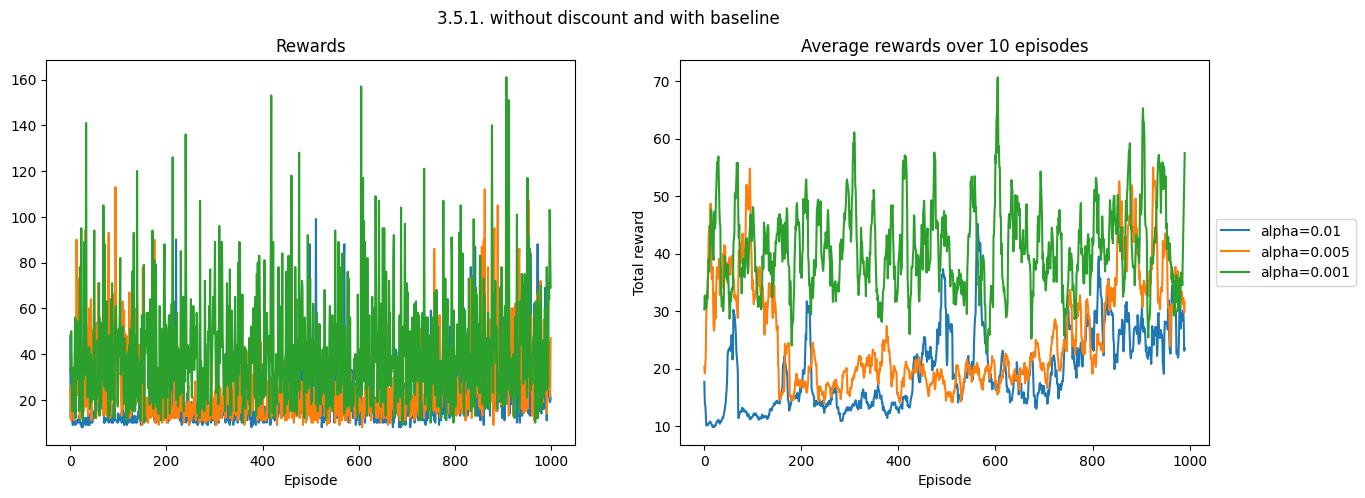

--------------------------------------------------------------------------------
[End] 3.5.1. without discount and with baseline
[Start] 3.5.1. with discount and with baseline
--------------------------------------------------------------------------------
[alpha=0.01] Episode 50: 10.0
[alpha=0.01] Episode 100: 10.0
[alpha=0.01] Episode 150: 11.0
[alpha=0.01] Episode 200: 86.0
[alpha=0.01] Episode 250: 37.0
[alpha=0.01] Episode 300: 25.0
[alpha=0.01] Episode 350: 39.0
[alpha=0.01] Episode 400: 41.0
[alpha=0.01] Episode 450: 17.0
[alpha=0.01] Episode 500: 20.0
[alpha=0.01] Episode 550: 58.0
[alpha=0.01] Episode 600: 77.0
[alpha=0.01] Episode 650: 131.0
[alpha=0.01] Episode 700: 48.0
[alpha=0.01] Episode 750: 100.0
[alpha=0.01] Episode 800: 94.0
[alpha=0.01] Episode 850: 121.0
[alpha=0.01] Episode 900: 36.0
[alpha=0.01] Episode 950: 99.0
[alpha=0.01] Episode 1000: 17.0
[alpha=0.005] Episode 50: 20.0
[alpha=0.005] Episode 100: 25.0
[alpha=0.005] Episode 150: 17.0
[alpha=0.005] Episode 200

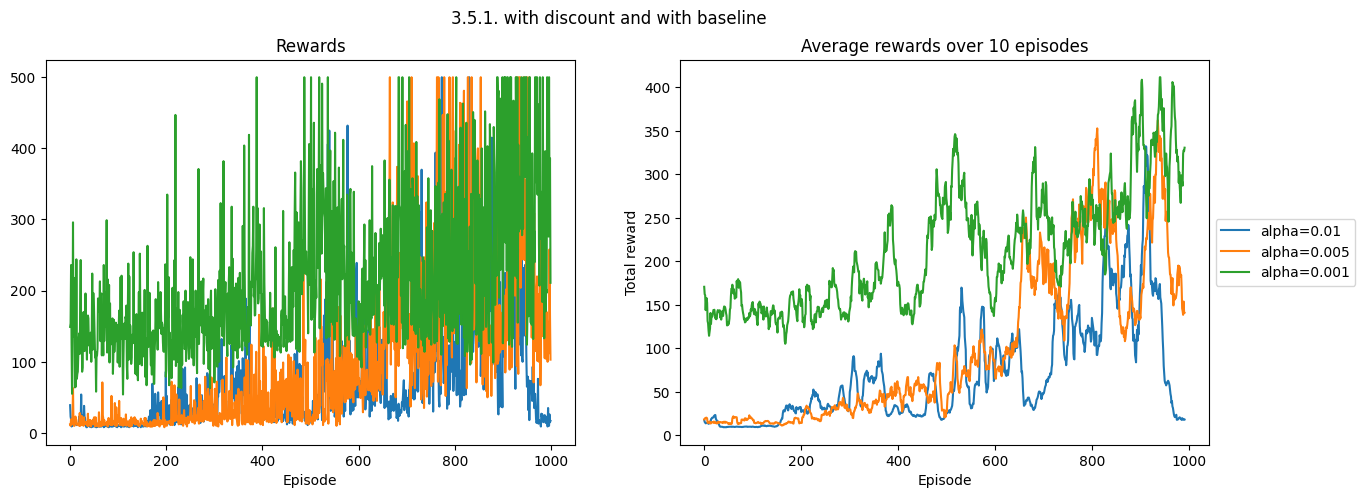

--------------------------------------------------------------------------------
[End] 3.5.1. with discount and with baseline
[Start] 3.5.3.1. [optimizer: SGD with Momentum] without discount and without baseline (A_t = R)
--------------------------------------------------------------------------------
[alpha=0.01] Episode 50: 10.0
[alpha=0.01] Episode 100: 10.0
[alpha=0.01] Episode 150: 9.0
[alpha=0.01] Episode 200: 9.0
[alpha=0.01] Episode 250: 10.0
[alpha=0.01] Episode 300: 8.0
[alpha=0.01] Episode 350: 10.0
[alpha=0.01] Episode 400: 10.0
[alpha=0.01] Episode 450: 10.0
[alpha=0.01] Episode 500: 9.0
[alpha=0.01] Episode 550: 9.0
[alpha=0.01] Episode 600: 9.0
[alpha=0.01] Episode 650: 9.0
[alpha=0.01] Episode 700: 9.0
[alpha=0.01] Episode 750: 10.0
[alpha=0.01] Episode 800: 10.0
[alpha=0.01] Episode 850: 9.0
[alpha=0.01] Episode 900: 8.0
[alpha=0.01] Episode 950: 9.0
[alpha=0.01] Episode 1000: 8.0
[alpha=0.005] Episode 50: 10.0
[alpha=0.005] Episode 100: 9.0
[alpha=0.005] Episode 150: 

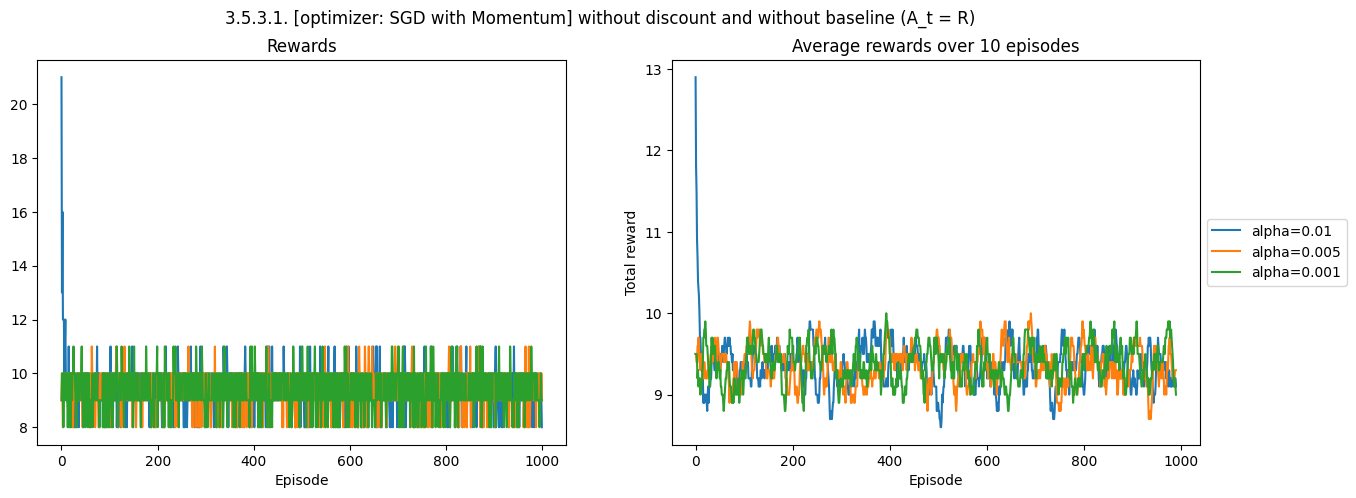

--------------------------------------------------------------------------------
[End] 3.5.3.1. [optimizer: SGD with Momentum] without discount and without baseline (A_t = R)
[Start] 3.5.3.1. [optimizer: SGD with Momentum] with discount and without baseline
--------------------------------------------------------------------------------
[alpha=0.01] Episode 50: 15.0
[alpha=0.01] Episode 100: 10.0
[alpha=0.01] Episode 150: 10.0
[alpha=0.01] Episode 200: 10.0
[alpha=0.01] Episode 250: 8.0
[alpha=0.01] Episode 300: 13.0
[alpha=0.01] Episode 350: 15.0
[alpha=0.01] Episode 400: 15.0
[alpha=0.01] Episode 450: 9.0
[alpha=0.01] Episode 500: 19.0
[alpha=0.01] Episode 550: 10.0
[alpha=0.01] Episode 600: 19.0
[alpha=0.01] Episode 650: 10.0
[alpha=0.01] Episode 700: 11.0
[alpha=0.01] Episode 750: 11.0
[alpha=0.01] Episode 800: 12.0
[alpha=0.01] Episode 850: 11.0
[alpha=0.01] Episode 900: 9.0
[alpha=0.01] Episode 950: 9.0
[alpha=0.01] Episode 1000: 10.0
[alpha=0.005] Episode 50: 12.0
[alpha=0.005] 

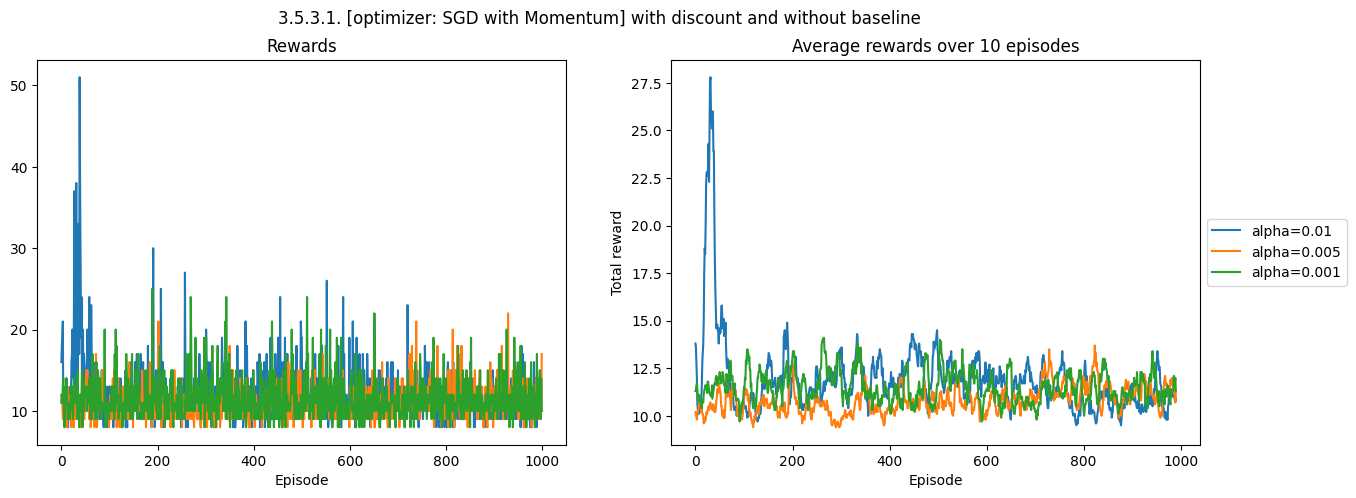

--------------------------------------------------------------------------------
[End] 3.5.3.1. [optimizer: SGD with Momentum] with discount and without baseline
[Start] 3.5.3.1. [optimizer: SGD with Momentum] without discount and with baseline
--------------------------------------------------------------------------------
[alpha=0.01] Episode 50: 17.0
[alpha=0.01] Episode 100: 10.0
[alpha=0.01] Episode 150: 11.0
[alpha=0.01] Episode 200: 9.0
[alpha=0.01] Episode 250: 11.0
[alpha=0.01] Episode 300: 10.0
[alpha=0.01] Episode 350: 9.0
[alpha=0.01] Episode 400: 10.0
[alpha=0.01] Episode 450: 9.0
[alpha=0.01] Episode 500: 9.0
[alpha=0.01] Episode 550: 10.0
[alpha=0.01] Episode 600: 12.0
[alpha=0.01] Episode 650: 9.0
[alpha=0.01] Episode 700: 9.0
[alpha=0.01] Episode 750: 13.0
[alpha=0.01] Episode 800: 19.0
[alpha=0.01] Episode 850: 10.0
[alpha=0.01] Episode 900: 13.0
[alpha=0.01] Episode 950: 15.0
[alpha=0.01] Episode 1000: 22.0
[alpha=0.005] Episode 50: 25.0
[alpha=0.005] Episode 100: 26

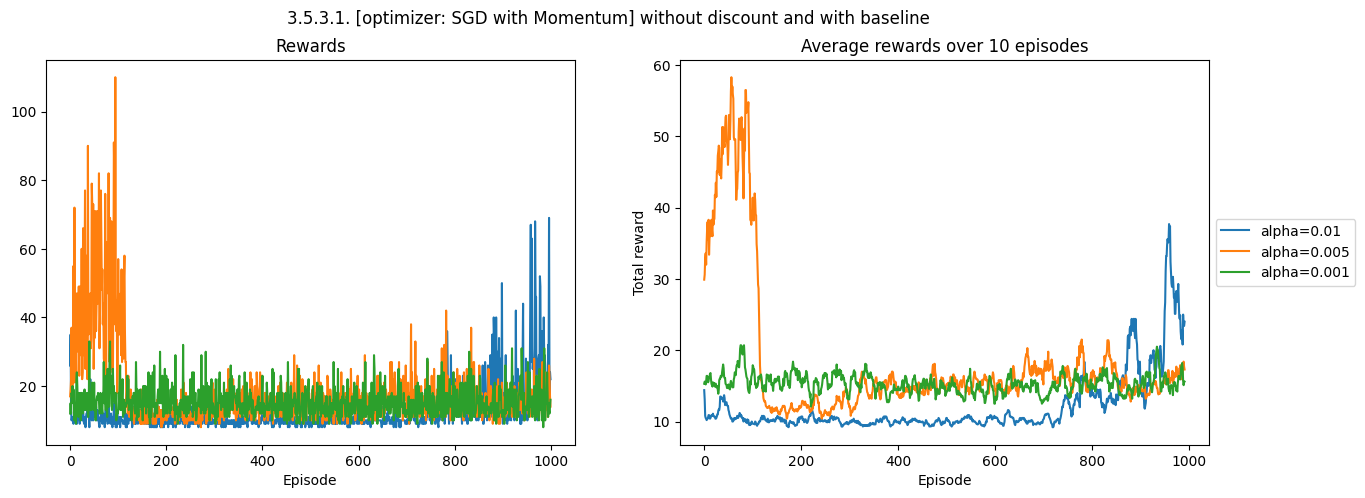

--------------------------------------------------------------------------------
[End] 3.5.3.1. [optimizer: SGD with Momentum] without discount and with baseline
[Start] 3.5.3.1. [optimizer: SGD with Momentum] with discount and with baseline
--------------------------------------------------------------------------------
[alpha=0.01] Episode 50: 11.0
[alpha=0.01] Episode 100: 8.0
[alpha=0.01] Episode 150: 13.0
[alpha=0.01] Episode 200: 11.0
[alpha=0.01] Episode 250: 20.0
[alpha=0.01] Episode 300: 12.0
[alpha=0.01] Episode 350: 10.0
[alpha=0.01] Episode 400: 15.0
[alpha=0.01] Episode 450: 14.0
[alpha=0.01] Episode 500: 11.0
[alpha=0.01] Episode 550: 16.0
[alpha=0.01] Episode 600: 17.0
[alpha=0.01] Episode 650: 11.0
[alpha=0.01] Episode 700: 18.0
[alpha=0.01] Episode 750: 11.0
[alpha=0.01] Episode 800: 11.0
[alpha=0.01] Episode 850: 17.0
[alpha=0.01] Episode 900: 21.0
[alpha=0.01] Episode 950: 17.0
[alpha=0.01] Episode 1000: 14.0
[alpha=0.005] Episode 50: 58.0
[alpha=0.005] Episode 100: 

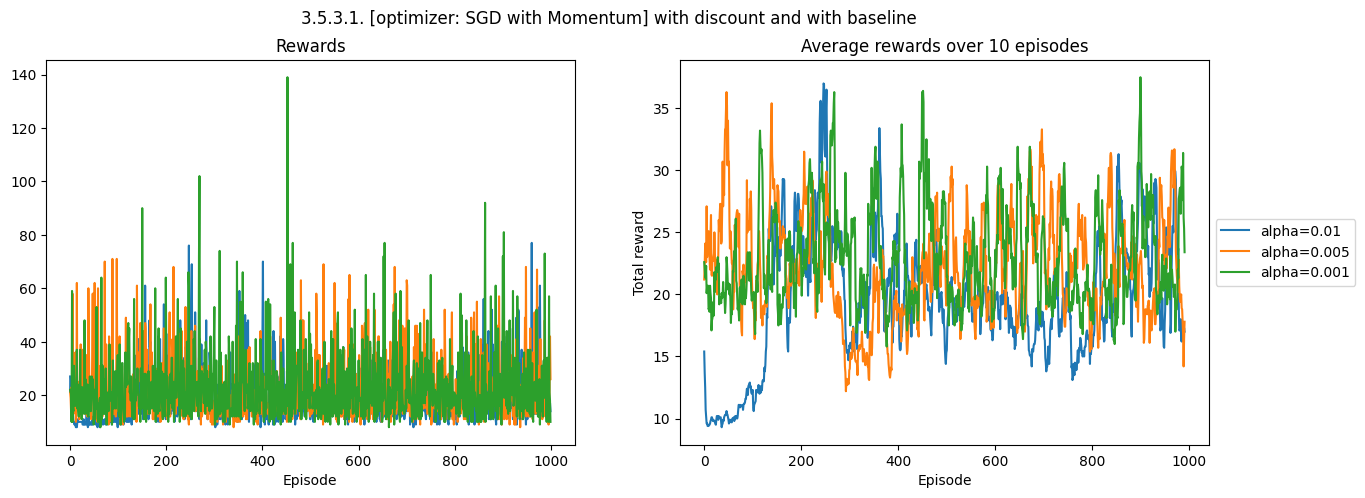

--------------------------------------------------------------------------------
[End] 3.5.3.1. [optimizer: SGD with Momentum] with discount and with baseline
[Start] 3.5.3.1. [optimizer: RMSProp] without discount and without baseline (A_t = R)
--------------------------------------------------------------------------------
[alpha=0.01] Episode 50: 9.0
[alpha=0.01] Episode 100: 10.0
[alpha=0.01] Episode 150: 11.0
[alpha=0.01] Episode 200: 12.0
[alpha=0.01] Episode 250: 14.0
[alpha=0.01] Episode 300: 33.0
[alpha=0.01] Episode 350: 76.0
[alpha=0.01] Episode 400: 50.0
[alpha=0.01] Episode 450: 52.0
[alpha=0.01] Episode 500: 65.0
[alpha=0.01] Episode 550: 170.0
[alpha=0.01] Episode 600: 161.0
[alpha=0.01] Episode 650: 99.0
[alpha=0.01] Episode 700: 98.0
[alpha=0.01] Episode 750: 118.0
[alpha=0.01] Episode 800: 349.0
[alpha=0.01] Episode 850: 50.0
[alpha=0.01] Episode 900: 343.0
[alpha=0.01] Episode 950: 500.0
[alpha=0.01] Episode 1000: 189.0
[alpha=0.005] Episode 50: 273.0
[alpha=0.005] Ep

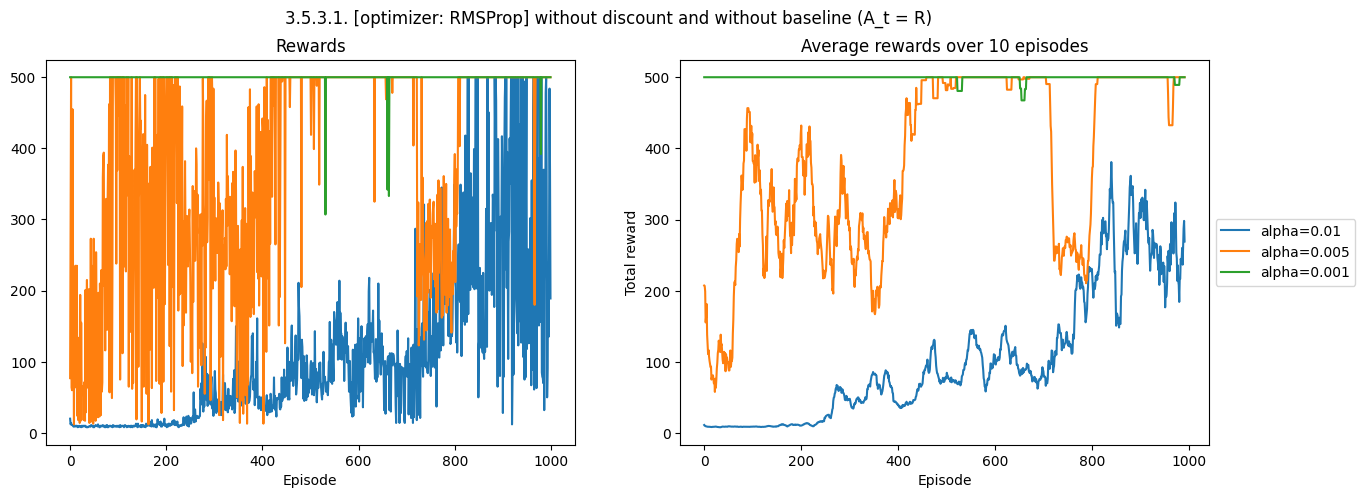

--------------------------------------------------------------------------------
[End] 3.5.3.1. [optimizer: RMSProp] without discount and without baseline (A_t = R)
[Start] 3.5.3.1. [optimizer: RMSProp] with discount and without baseline
--------------------------------------------------------------------------------
[alpha=0.01] Episode 50: 10.0
[alpha=0.01] Episode 100: 10.0
[alpha=0.01] Episode 150: 10.0
[alpha=0.01] Episode 200: 8.0
[alpha=0.01] Episode 250: 9.0
[alpha=0.01] Episode 300: 8.0
[alpha=0.01] Episode 350: 8.0
[alpha=0.01] Episode 400: 8.0
[alpha=0.01] Episode 450: 10.0
[alpha=0.01] Episode 500: 9.0
[alpha=0.01] Episode 550: 10.0
[alpha=0.01] Episode 600: 10.0
[alpha=0.01] Episode 650: 8.0
[alpha=0.01] Episode 700: 10.0
[alpha=0.01] Episode 750: 9.0
[alpha=0.01] Episode 800: 8.0
[alpha=0.01] Episode 850: 11.0
[alpha=0.01] Episode 900: 10.0
[alpha=0.01] Episode 950: 10.0
[alpha=0.01] Episode 1000: 10.0
[alpha=0.005] Episode 50: 10.0
[alpha=0.005] Episode 100: 10.0
[alpha=

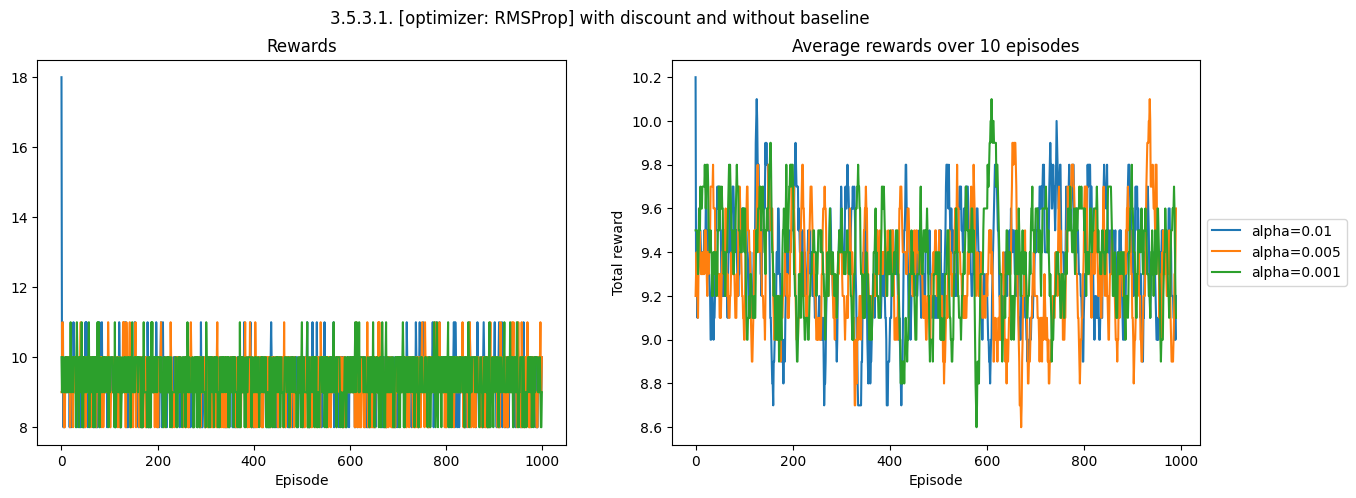

--------------------------------------------------------------------------------
[End] 3.5.3.1. [optimizer: RMSProp] with discount and without baseline
[Start] 3.5.3.1. [optimizer: RMSProp] without discount and with baseline
--------------------------------------------------------------------------------
[alpha=0.01] Episode 50: 33.0
[alpha=0.01] Episode 100: 150.0
[alpha=0.01] Episode 150: 45.0
[alpha=0.01] Episode 200: 129.0
[alpha=0.01] Episode 250: 153.0
[alpha=0.01] Episode 300: 117.0
[alpha=0.01] Episode 350: 186.0
[alpha=0.01] Episode 400: 136.0
[alpha=0.01] Episode 450: 157.0
[alpha=0.01] Episode 500: 161.0
[alpha=0.01] Episode 550: 350.0
[alpha=0.01] Episode 600: 227.0
[alpha=0.01] Episode 650: 500.0
[alpha=0.01] Episode 700: 380.0
[alpha=0.01] Episode 750: 500.0
[alpha=0.01] Episode 800: 500.0
[alpha=0.01] Episode 850: 500.0
[alpha=0.01] Episode 900: 260.0
[alpha=0.01] Episode 950: 145.0
[alpha=0.01] Episode 1000: 113.0
[alpha=0.005] Episode 50: 165.0
[alpha=0.005] Episode 10

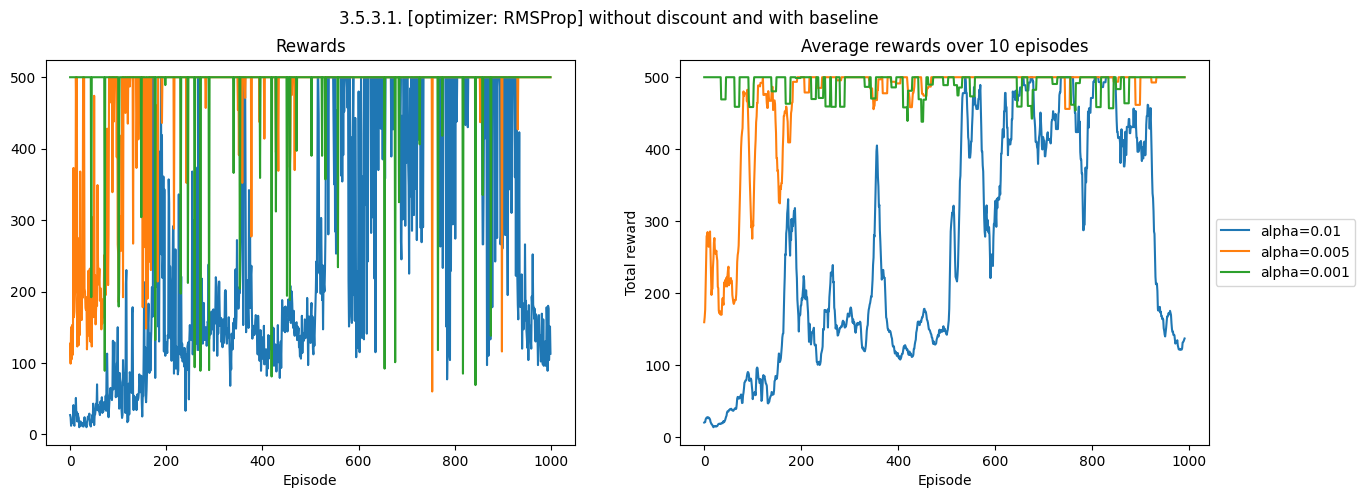

--------------------------------------------------------------------------------
[End] 3.5.3.1. [optimizer: RMSProp] without discount and with baseline
[Start] 3.5.3.1. [optimizer: RMSProp] with discount and with baseline
--------------------------------------------------------------------------------
[alpha=0.01] Episode 50: 106.0
[alpha=0.01] Episode 100: 500.0
[alpha=0.01] Episode 150: 472.0
[alpha=0.01] Episode 200: 122.0
[alpha=0.01] Episode 250: 112.0
[alpha=0.01] Episode 300: 500.0
[alpha=0.01] Episode 350: 297.0
[alpha=0.01] Episode 400: 203.0
[alpha=0.01] Episode 450: 172.0
[alpha=0.01] Episode 500: 58.0
[alpha=0.01] Episode 550: 220.0
[alpha=0.01] Episode 600: 500.0
[alpha=0.01] Episode 650: 463.0
[alpha=0.01] Episode 700: 212.0
[alpha=0.01] Episode 750: 149.0
[alpha=0.01] Episode 800: 197.0
[alpha=0.01] Episode 850: 358.0
[alpha=0.01] Episode 900: 173.0
[alpha=0.01] Episode 950: 109.0
[alpha=0.01] Episode 1000: 186.0
[alpha=0.005] Episode 50: 500.0
[alpha=0.005] Episode 100:

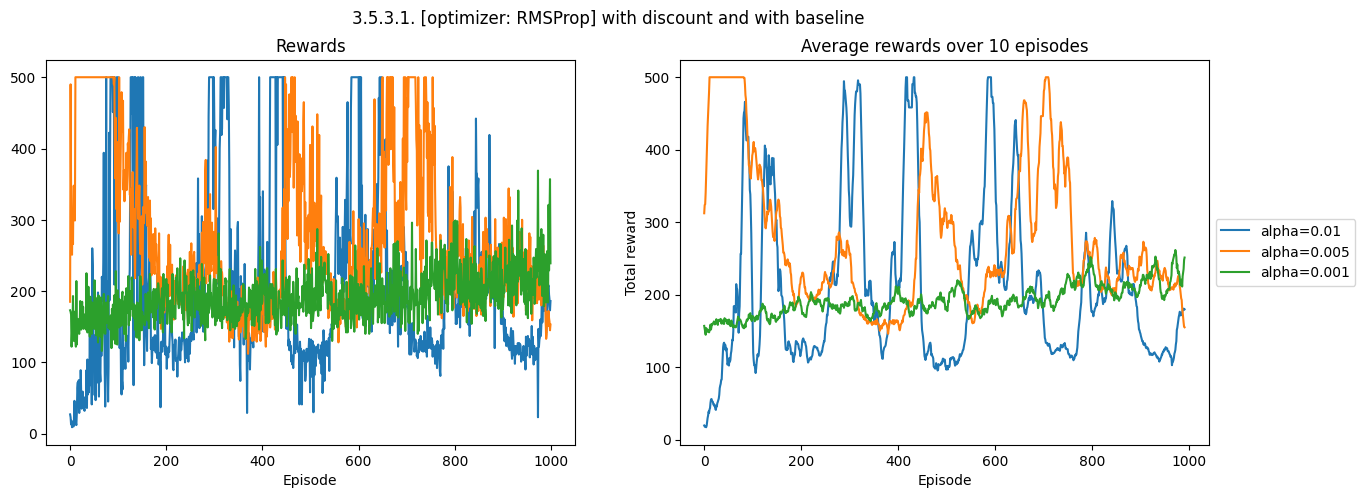

--------------------------------------------------------------------------------
[End] 3.5.3.1. [optimizer: RMSProp] with discount and with baseline
[Start] 3.5.3.1. [optimizer: Adam] without discount and without baseline (A_t = R)
--------------------------------------------------------------------------------
[alpha=0.01] Episode 50: 25.0
[alpha=0.01] Episode 100: 69.0
[alpha=0.01] Episode 150: 113.0
[alpha=0.01] Episode 200: 460.0
[alpha=0.01] Episode 250: 15.0
[alpha=0.01] Episode 300: 17.0
[alpha=0.01] Episode 350: 35.0
[alpha=0.01] Episode 400: 69.0
[alpha=0.01] Episode 450: 137.0
[alpha=0.01] Episode 500: 447.0
[alpha=0.01] Episode 550: 113.0
[alpha=0.01] Episode 600: 134.0
[alpha=0.01] Episode 650: 153.0
[alpha=0.01] Episode 700: 181.0
[alpha=0.01] Episode 750: 202.0
[alpha=0.01] Episode 800: 500.0
[alpha=0.01] Episode 850: 232.0
[alpha=0.01] Episode 900: 500.0
[alpha=0.01] Episode 950: 115.0
[alpha=0.01] Episode 1000: 119.0
[alpha=0.005] Episode 50: 124.0
[alpha=0.005] Episode

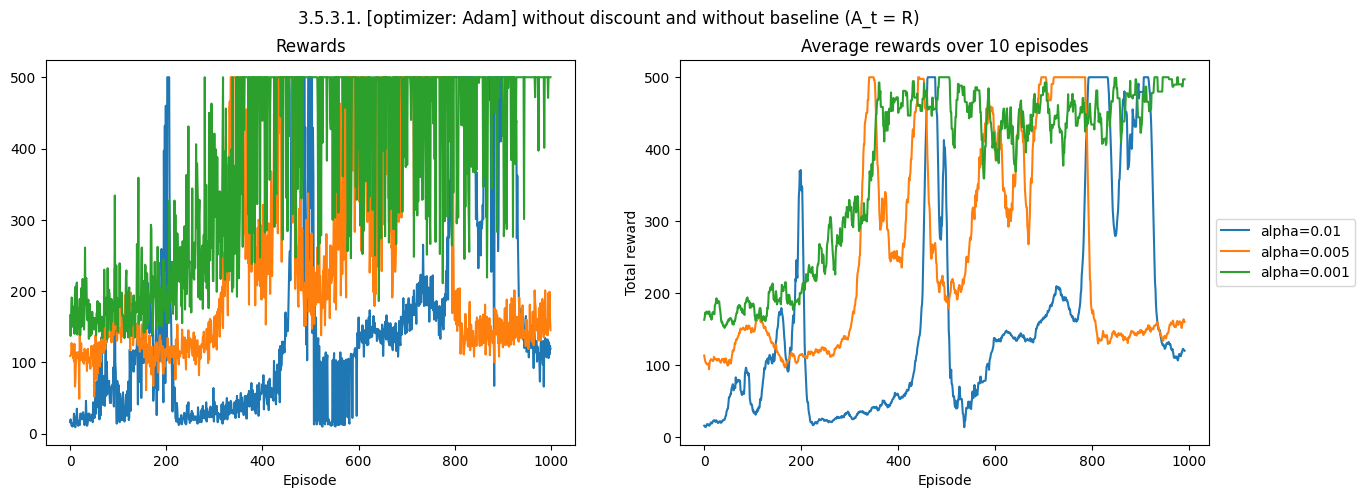

--------------------------------------------------------------------------------
[End] 3.5.3.1. [optimizer: Adam] without discount and without baseline (A_t = R)
[Start] 3.5.3.1. [optimizer: Adam] with discount and without baseline
--------------------------------------------------------------------------------
[alpha=0.01] Episode 50: 29.0
[alpha=0.01] Episode 100: 35.0
[alpha=0.01] Episode 150: 24.0
[alpha=0.01] Episode 200: 78.0
[alpha=0.01] Episode 250: 51.0
[alpha=0.01] Episode 300: 45.0
[alpha=0.01] Episode 350: 20.0
[alpha=0.01] Episode 400: 113.0
[alpha=0.01] Episode 450: 165.0
[alpha=0.01] Episode 500: 41.0
[alpha=0.01] Episode 550: 82.0
[alpha=0.01] Episode 600: 21.0
[alpha=0.01] Episode 650: 137.0
[alpha=0.01] Episode 700: 42.0
[alpha=0.01] Episode 750: 71.0
[alpha=0.01] Episode 800: 59.0
[alpha=0.01] Episode 850: 50.0
[alpha=0.01] Episode 900: 160.0
[alpha=0.01] Episode 950: 95.0
[alpha=0.01] Episode 1000: 36.0
[alpha=0.005] Episode 50: 75.0
[alpha=0.005] Episode 100: 129.0

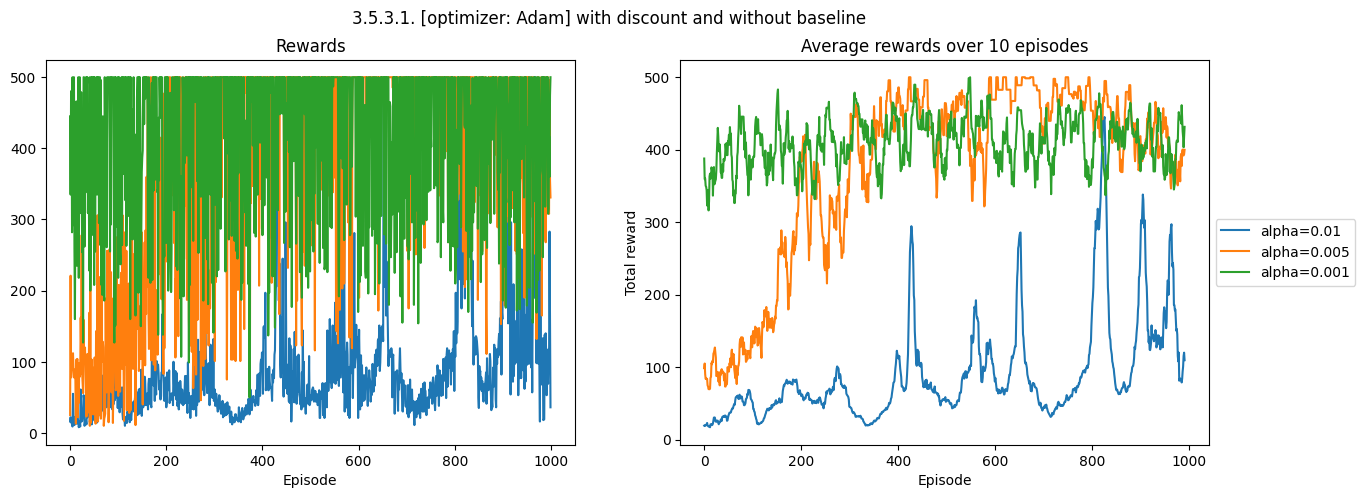

--------------------------------------------------------------------------------
[End] 3.5.3.1. [optimizer: Adam] with discount and without baseline
[Start] 3.5.3.1. [optimizer: Adam] without discount and with baseline
--------------------------------------------------------------------------------
[alpha=0.01] Episode 50: 91.0
[alpha=0.01] Episode 100: 93.0
[alpha=0.01] Episode 150: 417.0
[alpha=0.01] Episode 200: 124.0
[alpha=0.01] Episode 250: 223.0
[alpha=0.01] Episode 300: 13.0
[alpha=0.01] Episode 350: 483.0
[alpha=0.01] Episode 400: 500.0
[alpha=0.01] Episode 450: 74.0
[alpha=0.01] Episode 500: 376.0
[alpha=0.01] Episode 550: 237.0
[alpha=0.01] Episode 600: 169.0
[alpha=0.01] Episode 650: 18.0
[alpha=0.01] Episode 700: 367.0
[alpha=0.01] Episode 750: 500.0
[alpha=0.01] Episode 800: 150.0
[alpha=0.01] Episode 850: 500.0
[alpha=0.01] Episode 900: 500.0
[alpha=0.01] Episode 950: 139.0
[alpha=0.01] Episode 1000: 170.0
[alpha=0.005] Episode 50: 453.0
[alpha=0.005] Episode 100: 397.0


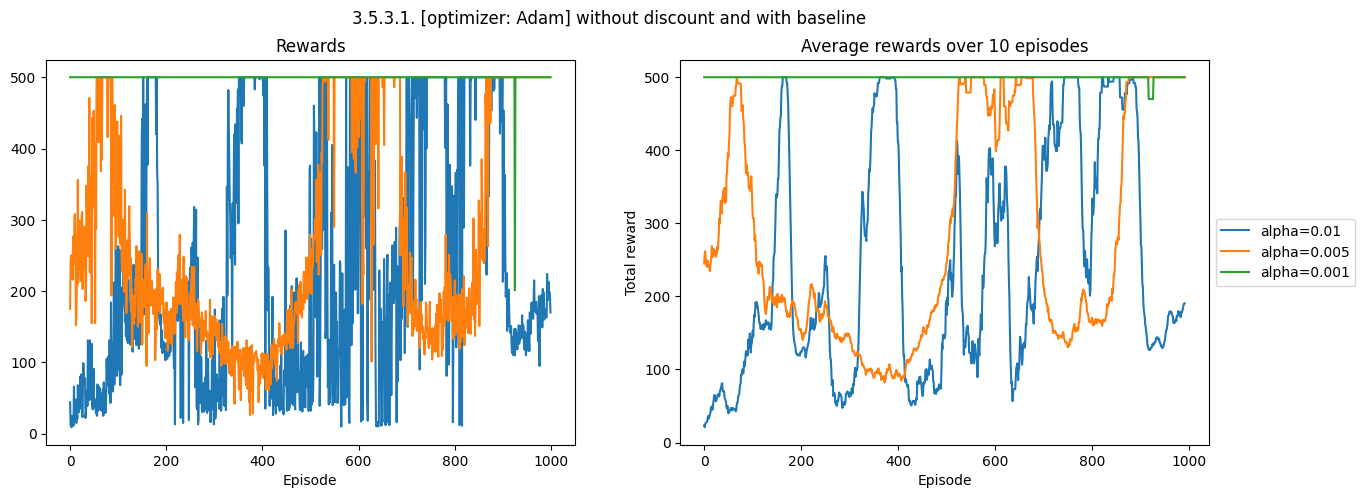

--------------------------------------------------------------------------------
[End] 3.5.3.1. [optimizer: Adam] without discount and with baseline
[Start] 3.5.3.1. [optimizer: Adam] with discount and with baseline
--------------------------------------------------------------------------------
[alpha=0.01] Episode 50: 11.0
[alpha=0.01] Episode 100: 52.0
[alpha=0.01] Episode 150: 63.0
[alpha=0.01] Episode 200: 183.0
[alpha=0.01] Episode 250: 413.0
[alpha=0.01] Episode 300: 432.0
[alpha=0.01] Episode 350: 302.0
[alpha=0.01] Episode 400: 140.0
[alpha=0.01] Episode 450: 500.0
[alpha=0.01] Episode 500: 341.0
[alpha=0.01] Episode 550: 500.0
[alpha=0.01] Episode 600: 224.0
[alpha=0.01] Episode 650: 397.0
[alpha=0.01] Episode 700: 500.0
[alpha=0.01] Episode 750: 284.0
[alpha=0.01] Episode 800: 500.0
[alpha=0.01] Episode 850: 500.0
[alpha=0.01] Episode 900: 500.0
[alpha=0.01] Episode 950: 500.0
[alpha=0.01] Episode 1000: 500.0
[alpha=0.005] Episode 50: 500.0
[alpha=0.005] Episode 100: 500.0
[

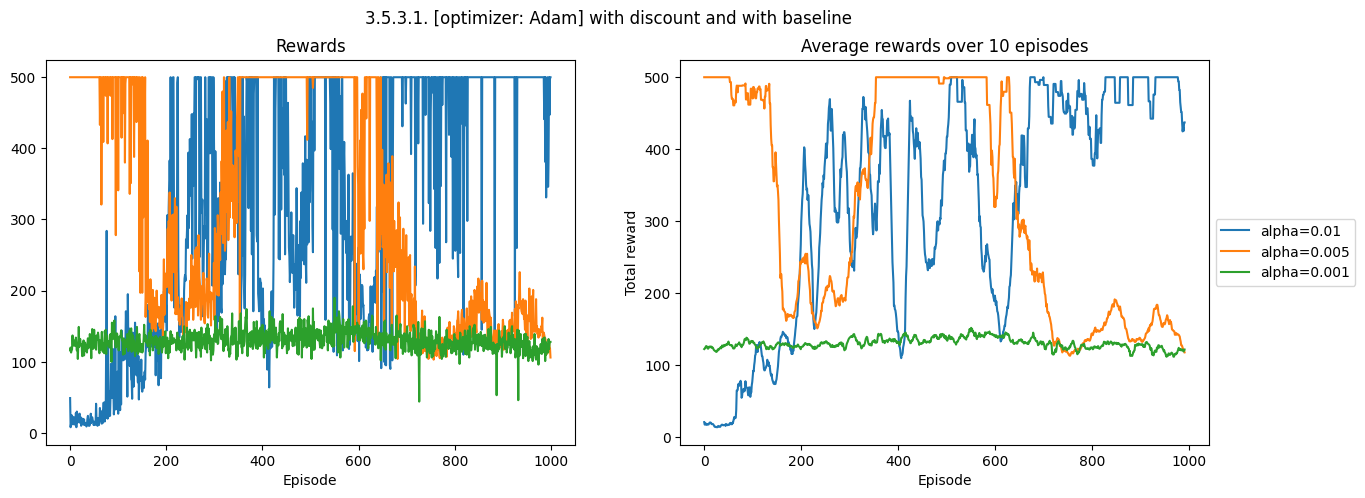

--------------------------------------------------------------------------------
[End] 3.5.3.1. [optimizer: Adam] with discount and with baseline


In [8]:
debug = False

def run(
    title: str,
    env_name: str,
    n_episodes = 1000,
    use_v_net: bool = False,
    discount = 1.0,
    seed = 42,
    get_optimizer = get_default_optimizer,
):
    print('=' * 80)
    print(f'[Start] {title}')
    print('-' * 80)
    np.random.seed(seed)
    torch.manual_seed(seed)
    env = gym.make(env_name)
    n_states = env.observation_space.shape[0]
    n_actions = env.action_space.n
    policy = GradientPolicy(n_states, n_actions)
    v_net = StateValueNetwork(n_states) if use_v_net else None
    manager = Manager(
        env=env,
        policy=policy,
        v_net=v_net,
        discount=discount,
        debug=debug,
        get_policy_optimizer=get_optimizer,
        get_v_optimizer=get_optimizer)
    manager.train(title=title, n_episodes=n_episodes)
    print('-' * 80)
    print(f'[End] {title}')
    print('=' * 80)

def run_cases(number: int, env_name: str, n_episodes = 1000):
    optimizers_fn = [
        (None, get_default_optimizer),
        ('SGD with Momentum', lambda model, lr: torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)),
        ('RMSProp', lambda model, lr: torch.optim.RMSprop(model.parameters(), lr=lr)),
        ('Adam', lambda model, lr: torch.optim.Adam(model.parameters(), lr=lr)),
    ]

    for optimizer_name, get_optimizer in optimizers_fn:
        optimizer_info = '' if optimizer_name is None else f' [optimizer: {optimizer_name}]'
        number_suffix = number if optimizer_name is None else f'3.{number}'
        run(
            f'3.5.{number_suffix}.{optimizer_info} without discount and without baseline (A_t = R)',
            env_name=env_name,
            n_episodes=n_episodes,
            use_v_net=False,
            discount=1.0,
            get_optimizer=get_optimizer)
        run(
            f'3.5.{number_suffix}.{optimizer_info} with discount and without baseline',
            env_name=env_name,
            n_episodes=n_episodes,
            use_v_net=False,
            discount=0.9,
            get_optimizer=get_optimizer)
        run(
            f'3.5.{number_suffix}.{optimizer_info} without discount and with baseline',
            env_name=env_name,
            n_episodes=n_episodes,
            use_v_net=True,
            discount=1.0,
            get_optimizer=get_optimizer)
        run(
            f'3.5.{number_suffix}.{optimizer_info} with discount and with baseline',
            env_name=env_name,
            n_episodes=n_episodes,
            use_v_net=True,
            discount=0.9,
            get_optimizer=get_optimizer)

run_cases(number=1, env_name='CartPole-v1', n_episodes = 1000)

The best cases were:

- RMSProp: alpha 0.001, without discount (with and without baseline)

- Adam: alpha 0.001, without discount and with baseline

Those 3 cases reached the maximum reward of 500 in less than 50 episodes (the number of steps to truncate the episode, taking into account that the agent receives 1 reward per time step).